In [152]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

#import pandas as pd
#import statsmodels

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# ______________________________________________________________________________
# Globals
nlayers = 25  # 13 (CSC) + 9 (RPC) + 3 (GEM)

#infile = '../test2/histos_tba.8.npz'
#infile = '../test2/histos_tba.9.npz'
infile = '../test2/histos_tba.10.npz'
#infile = '../test2/histos_tba_2GeV.10.npz'

chsqfile = '../test2/chsq.10.npz'


[INFO] Using numpy 1.12.1
[INFO] Using keras 2.0.5
[INFO] Using tensorflow 1.1.0
[INFO] Using sklearn 0.18.1


In [153]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_parameters = loaded['parameters']
    the_variables = loaded['variables']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3162532, 104)
[INFO] Loaded the parameters with shape (3162532, 3)


In [154]:
nentries = 100000

x_copy = the_variables[:nentries].copy()
y_copy = the_parameters[:nentries].copy()

In [155]:
x_phi   = x_copy[:, nlayers*0:nlayers*1]
x_theta = x_copy[:, nlayers*1:nlayers*2]
x_bend  = x_copy[:, nlayers*2:nlayers*3]
x_mask  = x_copy[:, nlayers*3:nlayers*4].astype(np.bool)  # this makes a copy
x_road  = x_copy[:, nlayers*4:nlayers*5]  # ipt, ieta, iphi, iphi_corr

y_pt    = y_copy[:, 0]
y_phi   = y_copy[:, 1]
y_eta   = y_copy[:, 2]

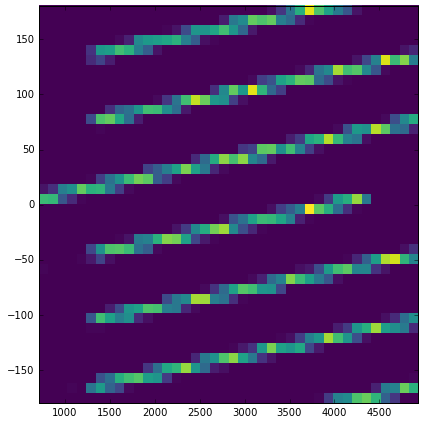

In [156]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

bad_ge21 = 23

x_i = x_phi[:, bad_ge21]
y_i = np.rad2deg(y_phi)
x_mask_i = x_mask[:, bad_ge21]
valid = ~x_mask_i

valid = valid & (-0.05 < y_pt) & (y_pt < 0.05)

_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)


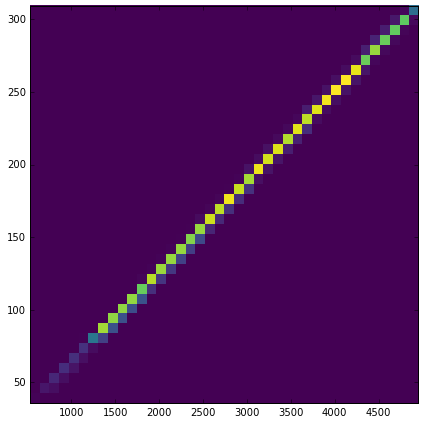

In [157]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

bad_ge21 = 23

x_i = x_phi[:, bad_ge21]
#y_i = np.rad2deg(y_phi)
y_i = x_road[:, 2]  # road iphi
x_mask_i = x_mask[:, bad_ge21]
valid = ~x_mask_i

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)


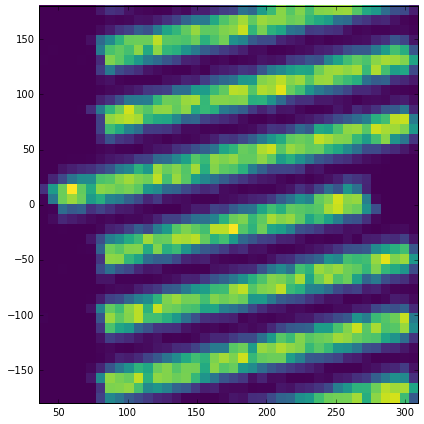

In [158]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

bad_ge21 = 23

x_i = x_road[:, 2]  # road iphi
y_i = np.rad2deg(y_phi)
x_mask_i = x_mask[:, bad_ge21]
valid = ~x_mask_i

#_ = ax.hist(x_i[valid], bins=40)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

_ = ax.hist2d(x_i, y_i, bins=40, cmap=plt.cm.viridis)

In [159]:
# Functions
def delta_phi(lhs, rhs):  # in radians
  rad = lhs - rhs
  while rad <  -np.pi:  rad += np.pi*2
  while rad >= +np.pi:  rad -= np.pi*2
  return rad

def delta_theta(lhs, rhs):  # in radians
  rad = lhs - rhs
  return rad

def range_phi_deg(deg):
  while deg <  -180.:
    deg += 360.
  while deg >= +180.:
    deg -= 360.
  return deg

def calc_phi_loc_deg_from_glob(glob, sector):
  # glob in deg, sector [1-6]
  glob = range_phi_deg(glob)
  loc = glob - 15. - (60. * (sector-1))
  return loc

def calc_phi_loc_int(glob, sector):
  # glob in deg, sector [1-6]
  loc = calc_phi_loc_deg_from_glob(glob, sector)
  if (loc + 22.) < 0.:
    loc += 360.
  loc = (loc + 22.) * 60.
  phi_int = int(round(loc))
  return phi_int

def calc_theta_int(theta, endcap):
  # theta in deg, endcap [-1,+1]
  if endcap == -1:
    theta = 180. - theta
  theta = (theta - 8.5) * 128./(45.0-8.5)
  theta_int = int(round(theta))
  return theta_int

def calc_theta_rad_from_eta(eta):
  theta = np.arctan2(1.0, np.sinh(eta))
  return theta

def calc_theta_deg_from_eta(eta):
  return np.rad2deg(calc_theta_rad_from_eta(eta))

def extrapolate_to_emtf(phi, invpt, eta):  # phi in radians
  # 1.204 is the magic constant at eta of 1.9
  eta_sf = np.sinh(1.9) / np.sinh(abs(eta))
  return phi - 1.204 * invpt * eta_sf

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(part.eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

In [160]:
phis = np.linspace(-np.pi, np.pi, 91)
sectors = [find_sector(phi) for phi in phis]
emtf_phis = [calc_phi_loc_int(np.rad2deg(phi), find_sector(phi)) for phi in phis]

phis = np.asarray(phis)
sectors = np.asarray(sectors)
emtf_phis = np.asarray(emtf_phis)
#print phis.flags.owndata

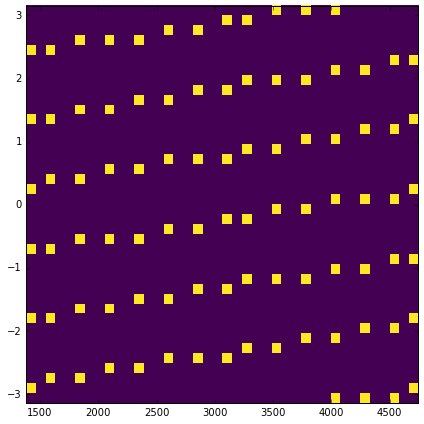

In [161]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

_ = ax.hist2d(emtf_phis, phis, bins=40, cmap=plt.cm.viridis)
#_ = ax.hist2d(emtf_phis[sectors==6], np.rad2deg(phis[sectors==6]), bins=40, cmap=plt.cm.viridis)

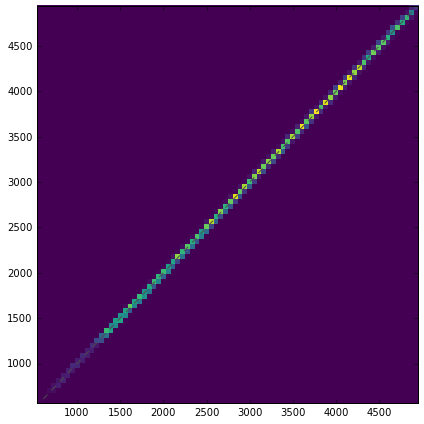

In [162]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

bad_ge21 = 23

x_i = x_phi[:, bad_ge21]
#y_i = np.rad2deg(y_phi)
y_i = x_road[:, 2]  # road iphi
y_i = y_i * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
x_mask_i = x_mask[:, bad_ge21]
valid = ~x_mask_i

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

_ = ax.plot((0,5000), (0,5000), ls="--", c=".3")

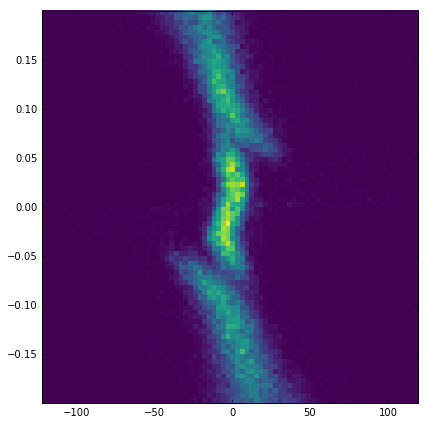

In [163]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

_ = ax.hist2d(x_i[valid] - y_i[valid], y_pt[valid], bins=80, cmap=plt.cm.viridis)

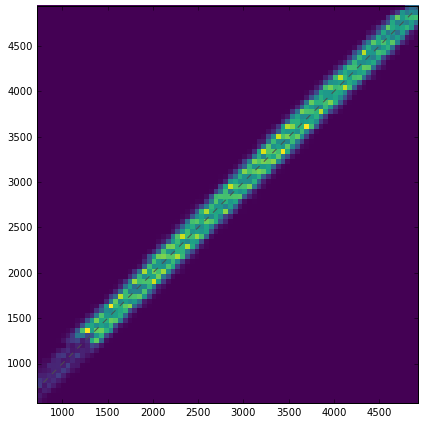

In [164]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

good_ge11 = 22

x_i = x_phi[:, good_ge11]
#y_i = np.rad2deg(y_phi)
y_i = x_road[:, 2]  # road iphi
y_i = y_i * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
x_mask_i = x_mask[:, good_ge11]
valid = ~x_mask_i

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

_ = ax.plot((0,5000), (0,5000), ls="--", c=".3")

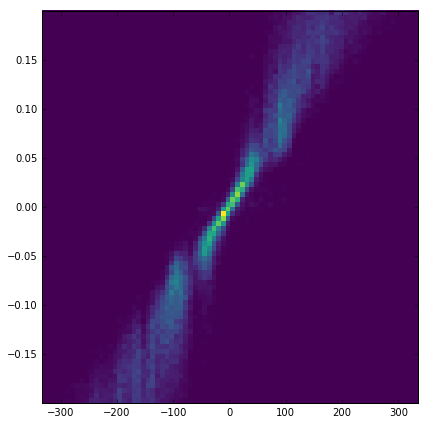

In [165]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

_ = ax.hist2d(x_i[valid] - y_i[valid], y_pt[valid], bins=80, cmap=plt.cm.viridis)

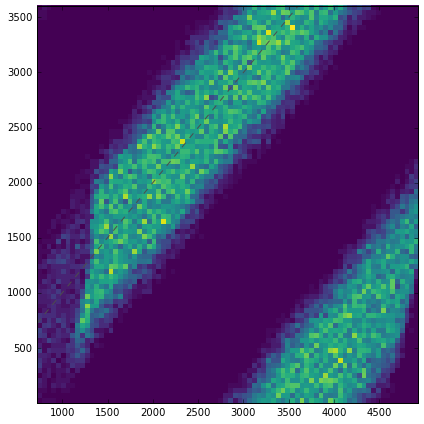

In [190]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

good_ge11 = 22

x_i = x_phi[:, good_ge11]
y_i = np.rad2deg(y_phi)
y_i = y_i - 15 + 22
y_i = np.where(y_i < 0., y_i + 360., y_i)
y_i = np.fmod(y_i, 60)
y_i = y_i * 60
#y_i = x_road[:, 2]  # road iphi
#y_i = y_i * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
x_mask_i = x_mask[:, good_ge11]
valid = ~x_mask_i

valid 

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

_ = ax.plot((0,5000), (0,5000), ls="--", c=".3")

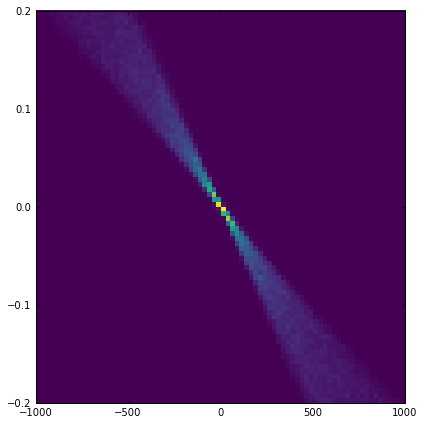

In [191]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

#_ = ax.hist2d(x_i[valid] - y_i[valid], y_pt[valid], bins=80, cmap=plt.cm.viridis)

xx_i = x_i[valid] - y_i[valid]

xx_i = np.where(xx_i > 1800, xx_i - 3600, xx_i)
xx_i = np.where(xx_i < 1800, xx_i + 3600, xx_i)
xx_i -= xx_i.mean()

xmin, xmax = -1000, 1000
ymin, ymax = -0.2, 0.2
_ = ax.hist2d(xx_i, y_pt[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

xx_i_old = xx_i

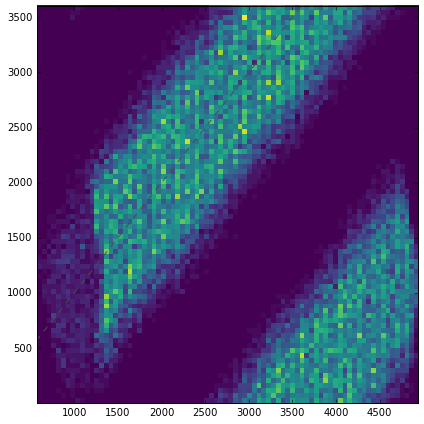

In [192]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

good_ge11 = 22

x_i = x_road[:, 2]  # road iphi
x_i = x_i * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
y_i = np.rad2deg(y_phi)
y_i = y_i - 15 + 22
y_i = np.where(y_i < 0., y_i + 360., y_i)
y_i = np.fmod(y_i, 60)
y_i = y_i * 60
#y_i = x_road[:, 2]  # road iphi
#y_i = y_i * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
x_mask_i = x_mask[:, good_ge11]
valid = ~x_mask_i

valid 

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

_ = ax.plot((0,5000), (0,5000), ls="--", c=".3")

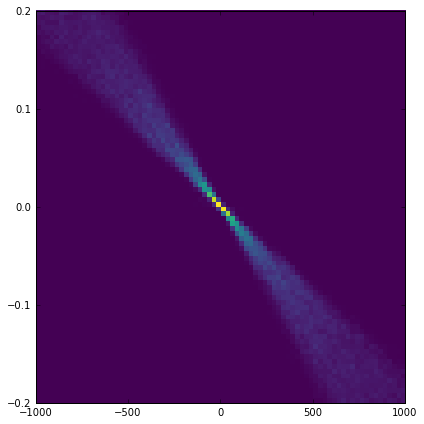

In [193]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

#_ = ax.hist2d(x_i[valid] - y_i[valid], y_pt[valid], bins=80, cmap=plt.cm.viridis)

xx_i = x_i[valid] - y_i[valid]

xx_i = np.where(xx_i > 1800, xx_i - 3600, xx_i)
xx_i = np.where(xx_i < 1800, xx_i + 3600, xx_i)
xx_i -= xx_i.mean()

xmin, xmax = -1000, 1000
ymin, ymax = -0.2, 0.2
_ = ax.hist2d(xx_i, y_pt[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

xx_i_new = xx_i

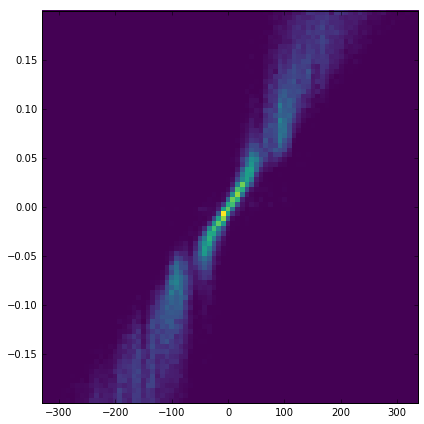

In [194]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

_ = ax.hist2d(xx_i_old - xx_i_new, y_pt[valid], bins=80, cmap=plt.cm.viridis)

-0.000282399
-0.000221724


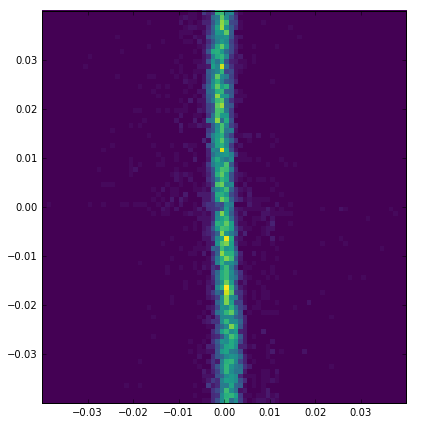

In [209]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

from sklearn.linear_model import LinearRegression
lr_old = LinearRegression(fit_intercept=False).fit(xx_i_old[:,np.newaxis], y_pt[valid])
print lr_old.coef_[0]
lr_new = LinearRegression(fit_intercept=False).fit(xx_i_new[:,np.newaxis], y_pt[valid])
print lr_new.coef_[0]

xmin, xmax = -0.04, 0.04
ymin, ymax = -0.04, 0.04
_ = ax.hist2d(xx_i_old * lr_old.coef_[0] - xx_i_new * lr_new.coef_[0], y_pt[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

[ 27.   32.   52.  ...,  19.   57.   19.5] [ 27.  32.  52. ...,  19.  57.  19.]


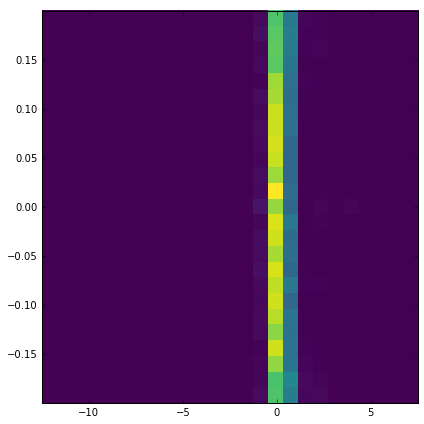

In [229]:
fig, ax = plt.subplots(tight_layout=True, figsize=(6,6))

theta_var = 8

x_check = np.nanmedian(x_theta, axis=1)
x_check_1 = np.nanpercentile(x_theta, 50, axis=1, interpolation='lower')
print x_check, x_check_1

x_i = x_theta[:, theta_var] - x_check
y_i = y_pt
x_mask_i = x_mask[:, theta_var]
valid = ~x_mask_i

valid 

#_ = ax.hist(x_i[valid], bins=40)
_ = ax.hist2d(x_i[valid], y_i[valid], bins=25, cmap=plt.cm.viridis)
#_ = ax.hist2d(x_i[valid], y_i[valid], bins=80, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)

#_ = ax.plot((0,5000), (0,5000), ls="--", c=".3")